In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import trieste
import gpflow
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import math
from util import plotting

2021-12-03 10:09:21.880547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 10:09:21.880565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-03 10:09:23.076363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 10:09:23.076725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 10:09:23.076771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [3]:
from trieste.objectives.multi_objectives import VLMOP2
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.data import Dataset
from trieste.models.gpflow.models import GPRStack
from trieste.models.gpflow.models import GaussianProcessRegression

from trieste.acquisition import BatchMonteCarloExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import BayesianOptimizer

In [4]:
from trieste.acquisition.multi_objective.pareto import Pareto, get_reference_point

## 1d case

In [5]:
search_space = trieste.space.Box([0], [2*math.pi])

def f1(x):
    return tf.cos(2 * x) + tf.sin(x)

def f2(x):
    return 0.2 * (tf.cos(x) - tf.sin(x)) + 0.3

def f(x):
    return tf.concat([f1(x), f2(x)], axis=-1)

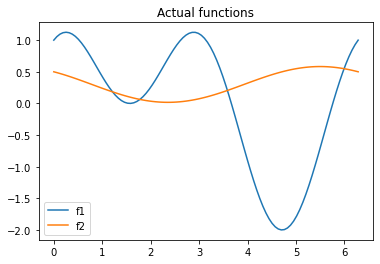

In [6]:
x_plot = np.linspace(start=search_space.lower[0], stop=search_space.upper[0], num=100)

plt.plot(x_plot, f1(x_plot), label="f1");
plt.plot(x_plot, f2(x_plot), label="f2");
plt.legend();
plt.title("Actual functions");
plt.show();

In [7]:
def build_stacked_independent_objectives_model(data: Dataset):
    gprs = []
    for idx in range(2):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        variance = tf.math.reduce_variance(single_obj_data.observations)
        kernel = gpflow.kernels.Matern52(variance, tf.constant(0.2, tf.float64))
        gpr = gpflow.models.GPR(single_obj_data.astuple(), kernel, noise_variance=1e-5)
        gpflow.utilities.set_trainable(gpr.likelihood, False)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return GPRStack(*gprs)

In [8]:
observer = mk_observer(f, OBJECTIVE)

In [9]:
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

In [10]:
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

2021-12-03 10:09:23.491579: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
num_steps = 3
num_query_points=4

acq_function = BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)

In [12]:
result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)
dataset = result.try_get_final_datasets()[OBJECTIVE]

2021-12-03 10:09:24.550651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 10:09:27.586510: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:09:30.995288: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:09:34.723320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9


Optimization completed without errors


In [13]:
models = result.try_get_final_models()[OBJECTIVE]._models

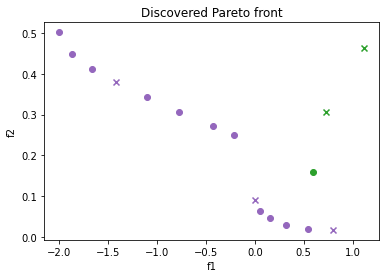

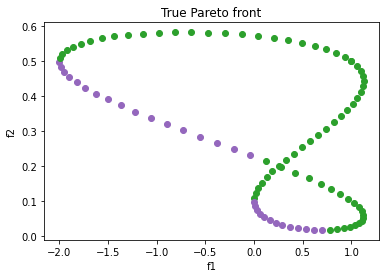

In [14]:
all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.stack([f1(x_plot), f2(x_plot)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();

In [15]:
from trieste.acquisition.function.local_penalization import MOLocalPenalizationAcquisitionFunction

In [16]:
acq_function = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

In [17]:
result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)
dataset = result.try_get_final_datasets()[OBJECTIVE]

Optimization completed without errors


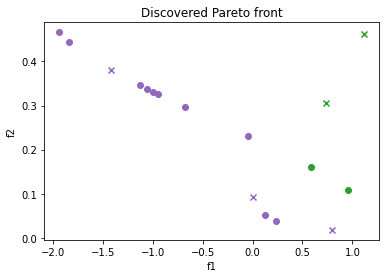

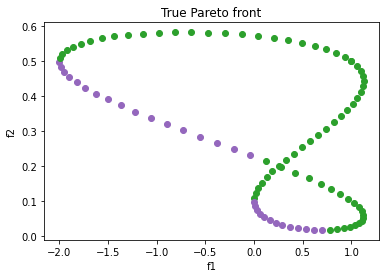

In [18]:
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.stack([f1(x_plot), f2(x_plot)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();

## 2d case

In [19]:
search_space = trieste.space.Box([0, 0], [2*math.pi, 2*math.pi])

def f1(input_data):
    x, y = input_data[..., -2], input_data[..., -1]
    z = tf.cos(2.0 * x) * tf.cos(y) + tf.sin(x)
    return z[:, None]

def f2(input_data):
    x, y = input_data[:, -2], input_data[:, -1]
    # changes are made so that the function is between 0 and 1
    z = 1.0 - (tf.cos(x) * tf.cos(y) - tf.sin(x) * tf.sin(y) + 1.0) / 2.0
    return z[:, None]

def f(x):
    return tf.concat([f1(x), f2(x)], axis=-1)

observer = mk_observer(f, OBJECTIVE)

In [20]:
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

In [21]:
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

num_steps = 10
num_query_points=4

acq_function = BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)

2021-12-03 10:09:56.698442: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:09:59.383216: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:10:02.238805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:10:05.504888: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:10:08.525538: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_gr

Optimization completed without errors


In [22]:
dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

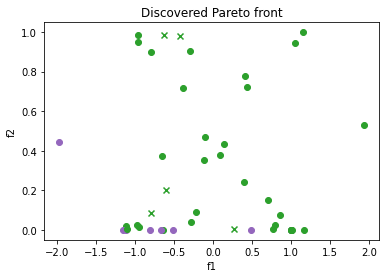

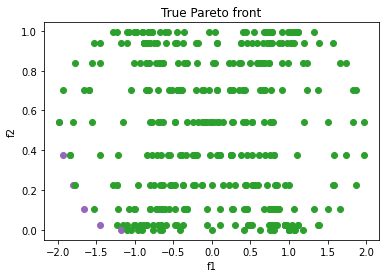

In [23]:
all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();

grid, xx, yy = plotting.create_grid(search_space.lower, search_space.upper, grid_density=20)

points_in_objective_space = f(grid)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();

In [24]:
acq_function = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)

Optimization completed without errors


In [25]:
dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

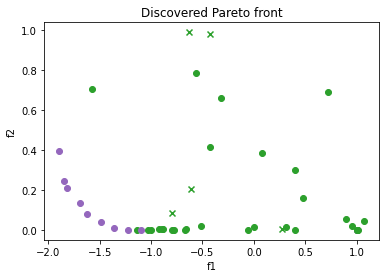

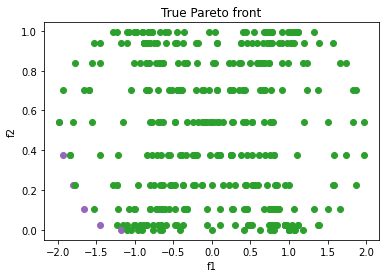

In [26]:
all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();

grid, xx, yy = plotting.create_grid(search_space.lower, search_space.upper, grid_density=20)

points_in_objective_space = f(grid)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("True Pareto front");
plt.show();

## Trieste integ tests

In [27]:
def test_multi_objective_optimizer_finds_pareto_front_of_the_VLMOP2_function(
    num_steps, acquisition_rule, convergence_threshold):
    tf.random.set_seed(0)
    search_space = Box([-2, -2], [2, 2])

    def build_stacked_independent_objectives_model(data: Dataset) -> ModelStack:
        gprs = []
        for idx in range(2):
            single_obj_data = Dataset(
                data.query_points, tf.gather(data.observations, [idx], axis=1)
            )
            variance = tf.math.reduce_variance(single_obj_data.observations)
            kernel = gpflow.kernels.Matern52(variance, tf.constant([0.2, 0.2], tf.float64))
            gpr = gpflow.models.GPR(single_obj_data.astuple(), kernel, noise_variance=1e-5)
            gpflow.utilities.set_trainable(gpr.likelihood, False)
            gprs.append((GaussianProcessRegression(gpr), 1))

        return ModelStack(*gprs)

    observer = mk_observer(VLMOP2().objective(), OBJECTIVE)

    initial_query_points = search_space.sample(10)
    initial_data = observer(initial_query_points)

    model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

    dataset = (
        BayesianOptimizer(observer, search_space)
        .optimize(num_steps, initial_data, {OBJECTIVE: model}, acquisition_rule)
        .try_get_final_datasets()[OBJECTIVE]
    )

    # A small log hypervolume difference corresponds to a succesful optimization.
    ref_point = get_reference_point(dataset.observations)

    obs_hv = Pareto(dataset.observations).hypervolume_indicator(ref_point)
    ideal_pf = tf.cast(VLMOP2().gen_pareto_optimal_points(100), dtype=tf.float64)
    ideal_hv = Pareto(ideal_pf).hypervolume_indicator(ref_point)

    assert tf.math.log(ideal_hv - obs_hv) < convergence_threshold

In [28]:
from trieste.acquisition import (
    BatchMonteCarloExpectedHypervolumeImprovement,
    ExpectedHypervolumeImprovement,
)
from trieste.acquisition.multi_objective.pareto import Pareto, get_reference_point
from trieste.acquisition.optimizer import generate_continuous_optimizer
from trieste.acquisition.rule import (
    AcquisitionRule,
    AsynchronousOptimization,
    EfficientGlobalOptimization,
)
from trieste.bayesian_optimizer import BayesianOptimizer
from trieste.data import Dataset
from trieste.models.gpflow import GaussianProcessRegression
from trieste.models.interfaces import ModelStack
from trieste.objectives.multi_objectives import VLMOP2
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE
from trieste.space import Box
from trieste.types import TensorType

In [29]:
input_params = [
    (
            15,
            EfficientGlobalOptimization(
                BatchMonteCarloExpectedHypervolumeImprovement(sample_size=500).using(OBJECTIVE),
                num_query_points=2,
                optimizer=generate_continuous_optimizer(num_initial_samples=500),
            ),
            -3.44,
    ),
    (
            10,
            EfficientGlobalOptimization(
                BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE),
                num_query_points=4,
                optimizer=generate_continuous_optimizer(num_initial_samples=500),
            ),
            -3.2095,
    ),
    
    
    # same as above, but with the new LP acq function
    (
            15,
            EfficientGlobalOptimization(
                MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE),
                num_query_points=2,
                optimizer=generate_continuous_optimizer(num_initial_samples=500),
            ),
            -3.44,
    ),
    (
            10,
            EfficientGlobalOptimization(
                MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE),
                num_query_points=4,
                optimizer=generate_continuous_optimizer(num_initial_samples=500),
            ),
            -3.2095,
    ),
]

In [30]:
for ip in input_params:
    print("-------------------------------")
    print("input:", ip)
    test_multi_objective_optimizer_finds_pareto_front_of_the_VLMOP2_function(ip[0], ip[1], ip[2])

-------------------------------
input: (15, EfficientGlobalOptimization(
        BatchMonteCarloExpectedHypervolumeImprovement(500, jitter=1e-06) using tag 'OBJECTIVE',
        <function batchify.<locals>.optimizer at 0x7f3c02ffecb0>,
        2), -3.44)


2021-12-03 10:11:17.399838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:19.254774: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:21.073245: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:23.153825: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:25.015955: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_gr

Optimization completed without errors
-------------------------------
input: (10, EfficientGlobalOptimization(
        BatchMonteCarloExpectedHypervolumeImprovement(250, jitter=1e-06) using tag 'OBJECTIVE',
        <function batchify.<locals>.optimizer at 0x7f3c2c0dc4d0>,
        4), -3.2095)


2021-12-03 10:11:47.032355: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:49.286958: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:51.306076: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:53.277657: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:11:55.371192: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_gr

Optimization completed without errors
-------------------------------
input: (15, EfficientGlobalOptimization(
        <trieste.acquisition.function.local_penalization.MOLocalPenalizationAcquisitionFunction object at 0x7f3c56573b10> using tag 'OBJECTIVE',
        <function generate_continuous_optimizer.<locals>.optimize_continuous at 0x7f3c1013d680>,
        2), -3.44)
Optimization completed without errors
-------------------------------
input: (10, EfficientGlobalOptimization(
        <trieste.acquisition.function.local_penalization.MOLocalPenalizationAcquisitionFunction object at 0x7f3c02fda6d0> using tag 'OBJECTIVE',
        <function generate_continuous_optimizer.<locals>.optimize_continuous at 0x7f3c10347680>,
        4), -3.2095)
Optimization completed without errors


## ZDT3

In [31]:
search_space = trieste.space.Box([0, 0], [1, 1])

def f1(x):
    return tf.reshape(x[:, 0], (-1, 1))

def f2(x):
    x1 = x[:, 0]
    n = tf.cast(tf.shape(x)[-1], tf.float64)
    g = 1.0 + tf.reduce_sum(x[:, 1:], axis=1) * 9.0 / (n - 1.0)
    h = 1 - tf.sqrt(x1 / g) - x1 / g * tf.sin(10.0 * math.pi * x1)
    return h[:, None]

def f(x):
    return tf.concat([f1(x), f2(x)], axis=-1)

observer = mk_observer(f, OBJECTIVE)

In [32]:
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

In [34]:
num_query_points = 5 # 10 runs out of memory and kills the kernel
num_steps = 20

model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

acq_function = BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)

2021-12-03 10:13:48.010909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:13:52.622895: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:13:57.976982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:14:03.930435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 10:14:09.459926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_gr

Optimization completed without errors


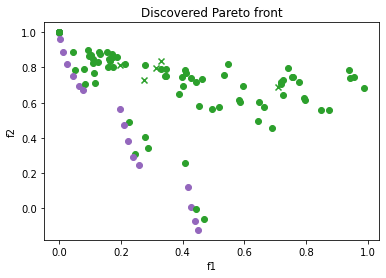

In [35]:
dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();

In [52]:
num_query_points = 5
num_steps = 20

acq_function = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)

Optimization completed without errors


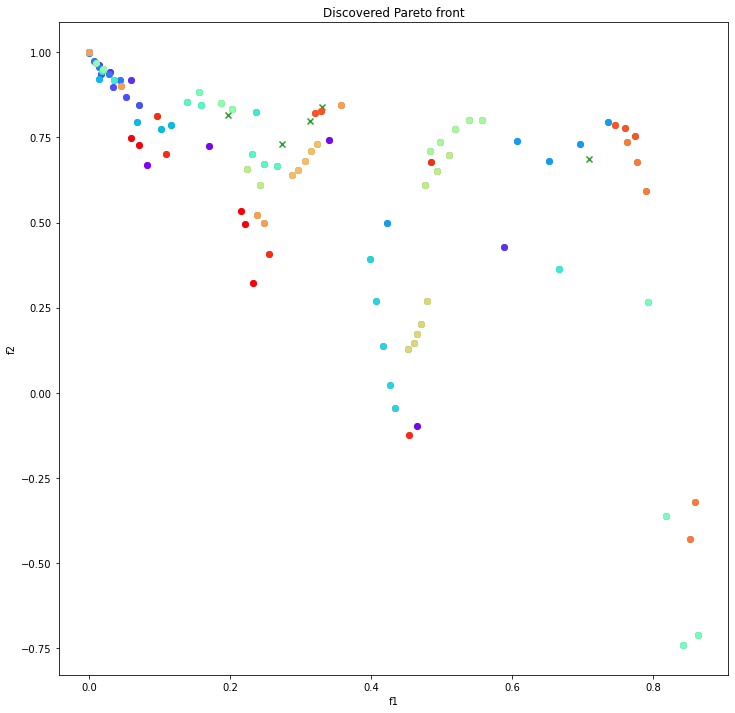

In [53]:
dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points, figsize=(12,12))

from matplotlib.pyplot import cm
colors = cm.rainbow(np.linspace(0, 1, num_steps))

for i in range(0, num_steps):
    start = num_initial_points + i*num_query_points
    end = num_initial_points + (i+1)*num_query_points
    plt.scatter(f1_model_values[start:end, :], f2_model_values[start:end, :], color=colors[i])

plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();

Optimization completed without errors


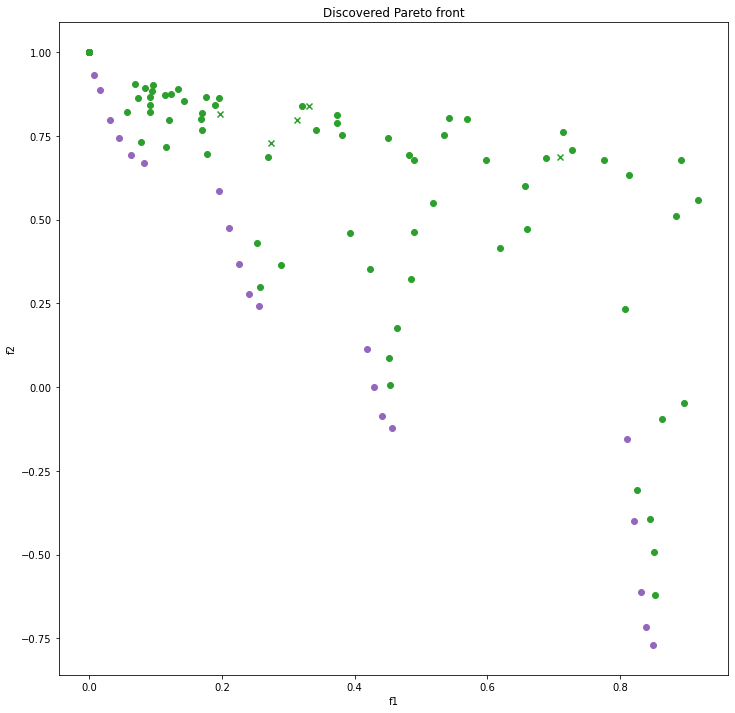

In [49]:
num_steps = 100

from trieste.acquisition.function.multi_objective import ExpectedHypervolumeImprovement

acq_function = ExpectedHypervolumeImprovement().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)


dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points, figsize=(12,12))

# from matplotlib.pyplot import cm
# colors = cm.rainbow(np.linspace(0, 1, num_steps))

# for i in range(0, num_steps):
#     start = num_initial_points + i*num_query_points
#     end = num_initial_points + (i+1)*num_query_points
#     plt.scatter(f1_model_values[start:end, :], f2_model_values[start:end, :], color=colors[i])

plt.xlabel("f1");
plt.ylabel("f2");
plt.title("Discovered Pareto front");
plt.show();

## Hartmann and Ackley

In [55]:
from trieste.objectives.single_objectives import hartmann_6, ackley_5

In [61]:
# Ackley funciton in Trieste is defined over 5d domain, and we want
def ackley_6(x: TensorType) -> TensorType:
    tf.debugging.assert_shapes([(x, (..., 6))])
    
    x_5d = x[..., :-1]

    return ackley_5(x_5d)

In [72]:
search_space = trieste.space.Box([0]*6, [1]*6)

def f(x):
    return tf.concat([hartmann_6(x), ackley_6(x)], axis=-1)

observer = mk_observer(f, OBJECTIVE)

In [75]:
num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

2021-12-03 15:34:50.403341: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 15:34:55.068022: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 15:34:59.562409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 15:35:04.644275: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_greater_equal/Assert/AssertGuard/branch_executed/_9
2021-12-03 15:35:11.566692: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_gr

Optimization completed without errors


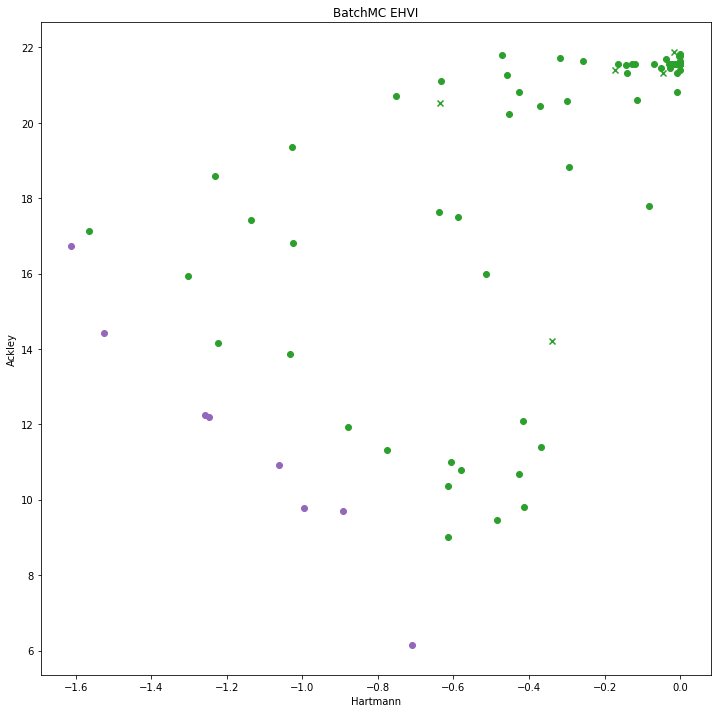

In [79]:
num_query_points = 5
num_steps = 20

model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

acq_function = BatchMonteCarloExpectedHypervolumeImprovement(sample_size=250).using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)

dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points, figsize=(12,12))

# from matplotlib.pyplot import cm
# colors = cm.rainbow(np.linspace(0, 1, num_steps))

# for i in range(0, num_steps):
#     start = num_initial_points + i*num_query_points
#     end = num_initial_points + (i+1)*num_query_points
#     plt.scatter(f1_model_values[start:end, :], f2_model_values[start:end, :], color=colors[i])

plt.xlabel("Hartmann");
plt.ylabel("Ackley");
plt.title("BatchMC EHVI");
plt.show();

Optimization completed without errors


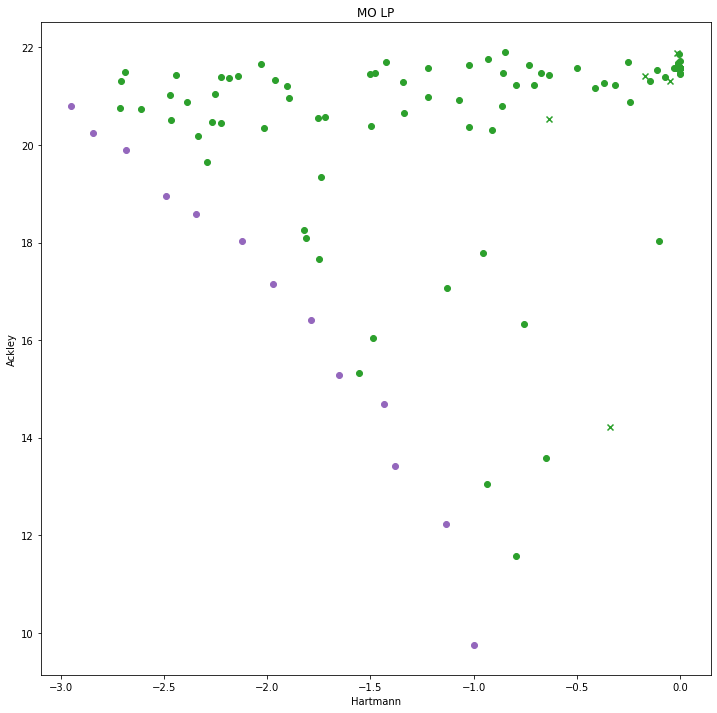

In [81]:
num_query_points = 5
num_steps = 20

acq_function = MOLocalPenalizationAcquisitionFunction().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function, num_query_points=num_query_points)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)

dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points, figsize=(12,12))

# from matplotlib.pyplot import cm
# colors = cm.rainbow(np.linspace(0, 1, num_steps))

# for i in range(0, num_steps):
#     start = num_initial_points + i*num_query_points
#     end = num_initial_points + (i+1)*num_query_points
#     plt.scatter(f1_model_values[start:end, :], f2_model_values[start:end, :], color=colors[i])

plt.xlabel("Hartmann");
plt.ylabel("Ackley");
plt.title("MO LP");
plt.show();

Optimization completed without errors


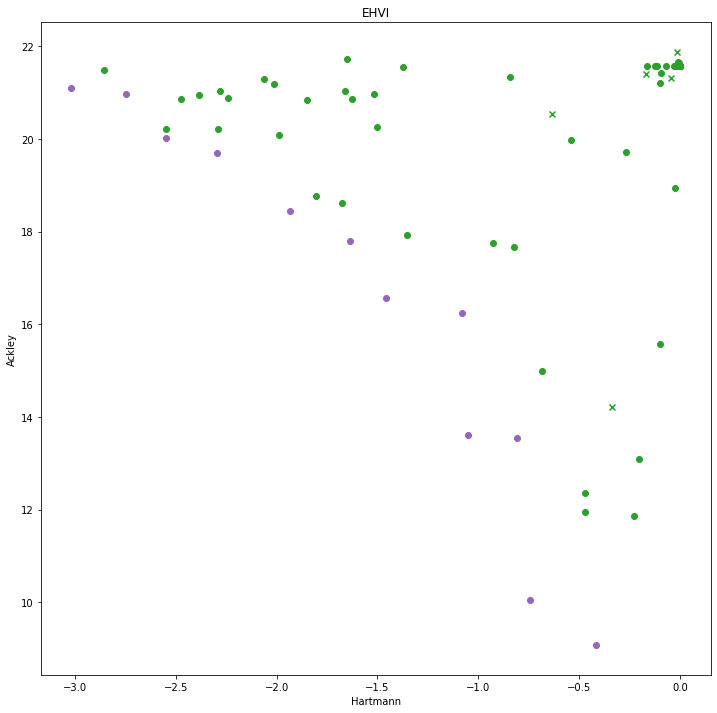

In [82]:
num_steps = 100

from trieste.acquisition.function.multi_objective import ExpectedHypervolumeImprovement

acq_function = ExpectedHypervolumeImprovement().using(OBJECTIVE)
acq_rule = EfficientGlobalOptimization(acq_function)
model = build_stacked_independent_objectives_model(initial_data[OBJECTIVE])

result = BayesianOptimizer(observer, search_space).optimize(num_steps, initial_data, {OBJECTIVE: model}, acq_rule)


dataset = result.try_get_final_datasets()[OBJECTIVE]
models = result.try_get_final_models()[OBJECTIVE]._models

all_query_points = dataset.query_points
f1_model_values, _ = models[0].predict(all_query_points)
f2_model_values, _ = models[1].predict(all_query_points)

points_in_objective_space = tf.concat([f1_model_values, f2_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points, figsize=(12,12))

# from matplotlib.pyplot import cm
# colors = cm.rainbow(np.linspace(0, 1, num_steps))

# for i in range(0, num_steps):
#     start = num_initial_points + i*num_query_points
#     end = num_initial_points + (i+1)*num_query_points
#     plt.scatter(f1_model_values[start:end, :], f2_model_values[start:end, :], color=colors[i])

plt.xlabel("Hartmann");
plt.ylabel("Ackley");
plt.title("EHVI");
plt.show();